In [ ]:
# Step 1: Install and Import Required Libraries
!pip install tensorflow keras
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# Step 2: Mount Google Drive and Define Dataset Path
from google.colab import drive
drive.mount('/content/drive')

dataset_dir = '/content/drive/MyDrive/Dog_Breed_Dataset/'  # Path to your dataset on Google Drive
model_save_path = '/content/drive/MyDrive/Colab Notebooks/improved_dog_breed_model.keras'  # Save path for the model

print("Dataset Directory:", dataset_dir)
print("Subdirectories (Breeds):", os.listdir(dataset_dir))

Mounted at /content/drive
Dataset Directory: /content/drive/MyDrive/Dog_Breed_Dataset/
Subdirectories (Breeds): ['Pug', 'Rottweiler', 'Shih_tzu', 'German_Shepherd', 'Husky', 'Dalmation']


In [ ]:
# Step 3: Data Preprocessing with Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0,1]
    rotation_range=40,                # Random rotation
    width_shift_range=0.3,            # Horizontal shift
    height_shift_range=0.3,           # Vertical shift
    shear_range=0.3,                  # Shearing transformations
    zoom_range=0.3,                   # Zooming in on images
    horizontal_flip=True,             # Flip images horizontally
    fill_mode='nearest',              # Fill empty pixels after transformations
    validation_split=0.2              # 80% training, 20% validation
)

# Load the training and validation data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),           # ResNet50 expects 224x224 input images
    batch_size=32,                    # Batch size
    class_mode='categorical',         # Multi-class classification
    subset='training'                 # Set as training data
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'               # Set as validation data
)


Found 2688 images belonging to 6 classes.
Found 672 images belonging to 6 classes.


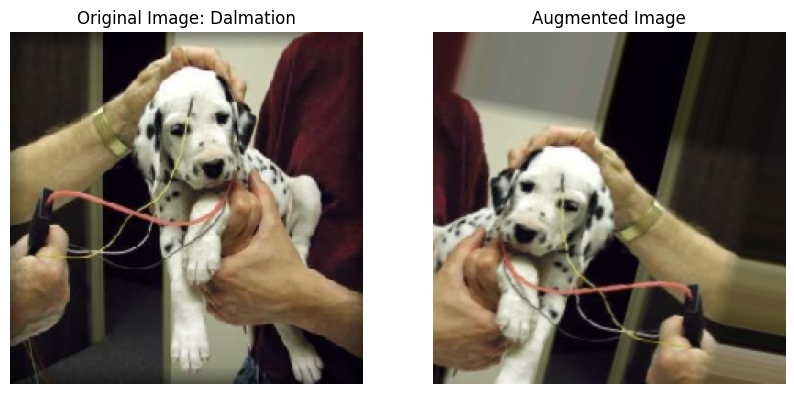

In [ ]:
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 4: Display a Random Original and Augmented Image
def show_random_augmented_image():
    # Get a random class (dog breed) from the dataset
    class_names = os.listdir(dataset_dir)
    random_class = random.choice(class_names)

    # Get all images in the randomly selected class directory
    class_dir = os.path.join(dataset_dir, random_class)
    image_files = os.listdir(class_dir)

    # Randomly select an image file
    random_image_file = random.choice(image_files)
    image_path = os.path.join(class_dir, random_image_file)

    # Load the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)

    # Create an ImageDataGenerator for augmentation (with the same parameters)
    augmentation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Apply the augmentation to the original image
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    augmented_image_batch = augmentation_datagen.flow(img_array, batch_size=1)

    # Get the first augmented image from the batch using __next__()
    augmented_image = next(augmented_image_batch)[0]

    # Plot the original and augmented images side by side
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image: {random_class}")
    plt.axis('off')

    # Augmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.axis('off')

    plt.show()

# Call the function to show the images
show_random_augmented_image()


In [ ]:
# Step 4: Build the Model Using Pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of ResNet50 for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers for fine-tuning
    layer.trainable = True

# Add custom layers on top of ResNet50
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),         # Global pooling to reduce feature map size
    Dropout(0.5),                     # Add dropout to prevent overfitting
    Dense(256, activation='relu', kernel_regularizer='l2'),  # L2 regularization
    Dropout(0.5),                     # Dropout to prevent overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer (number of breeds)
])

KeyboardInterrupt: 

In [ ]:
# Step 5: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.00005),  # Slightly higher learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 6: Early Stopping, Reduce Learning Rate, and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Patience increased to 15
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)  # Lower LR if no improvement
model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)

In [ ]:
# Step 7: Train the Model with 50 Epochs
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=40,  # Adjusted to 50 epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 1377s 15s/step - accuracy: 0.3646 - loss: 6.4907 - val_accuracy: 0.1682 - val_loss: 6.4751 - learning_rate: 5.0000e-05
Epoch 2/40


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 3/40


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 722ms/step - accuracy: 0.8803 - loss: 4.7982 - val_accuracy: 0.1637 - val_loss: 6.4301 - learning_rate: 5.0000e-05
Epoch 4/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 5/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 737ms/step - accuracy: 0.9456 - loss: 4.5273 - val_accuracy: 0.1682 - val_loss: 6.4194 - learning_rate: 5.0000e-05
Epoch 6/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 7/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 743ms/step - accuracy: 0.9543 - loss: 4.3536 - val_accuracy: 0.1696 - val_loss: 6.6902 - learning_rate: 5.0000e-05
Epoch 8/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 9/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 790ms/step - accuracy: 0.9627 - loss: 4.1944 - val_accuracy: 0.1815 - val_loss: 6.0473 - learning_rate: 5.0000e-05
Epoch 10/40
84/84

In [ ]:
# Step 8: Calculate Overall Training and Validation Accuracy
overall_training_accuracy = history.history['accuracy'][-1] * 100  # Last epoch's training accuracy
overall_validation_accuracy = history.history['val_accuracy'][-1] * 100  # Last epoch's validation accuracy


# Print training and validation accuracy
print(f'Overall Training Accuracy: {overall_training_accuracy:.2f}%')
print(f'Overall Validation Accuracy: {overall_validation_accuracy:.2f}%')


Overall Training Accuracy: 0.00%
Overall Validation Accuracy: 96.58%


In [ ]:
#Overall training and efficiency of the model
avg_training_accuracy = np.mean(history.history['accuracy']) * 100
avg_validation_accuracy = np.mean(history.history['val_accuracy']) * 100
print(f'Average Training Accuracy: {avg_training_accuracy:.2f}%')
print(f'Average Validation Accuracy: {avg_validation_accuracy:.2f}%')

Average Training Accuracy: 47.52%
Average Validation Accuracy: 63.79%


In [ ]:
# Step 9: Evaluate the Model on the Validation Set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 564ms/step - accuracy: 0.9722 - loss: 1.9989
Final Validation Loss: 1.9677, Final Validation Accuracy: 97.47%


In [ ]:

# Step 10: Save the Model in Google Drive (already specified in the checkpoint)
model.save(model_save_path)
model.save('/content/drive/MyDrive/Colab Notebooks/improved.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,235,156 (275.56 MB)

 Trainable params: 24,060,678 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,121,358 (183.57 MB)

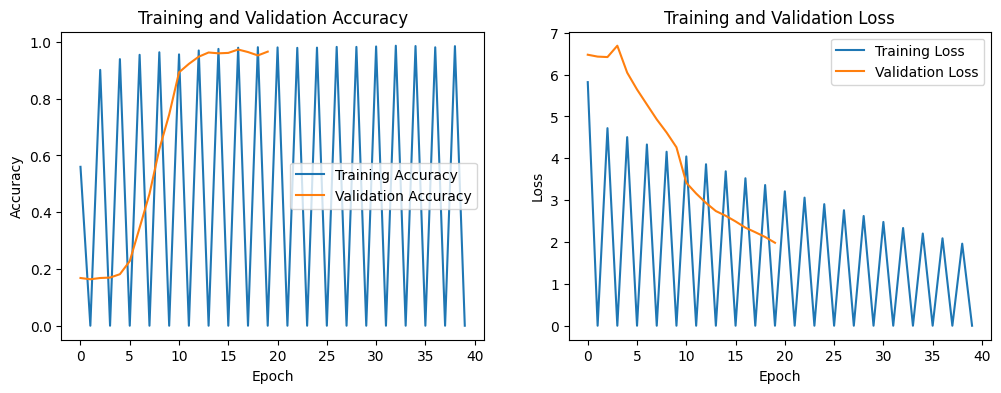

In [ ]:
# Step 11: Visualize the Training Process
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 555ms/step


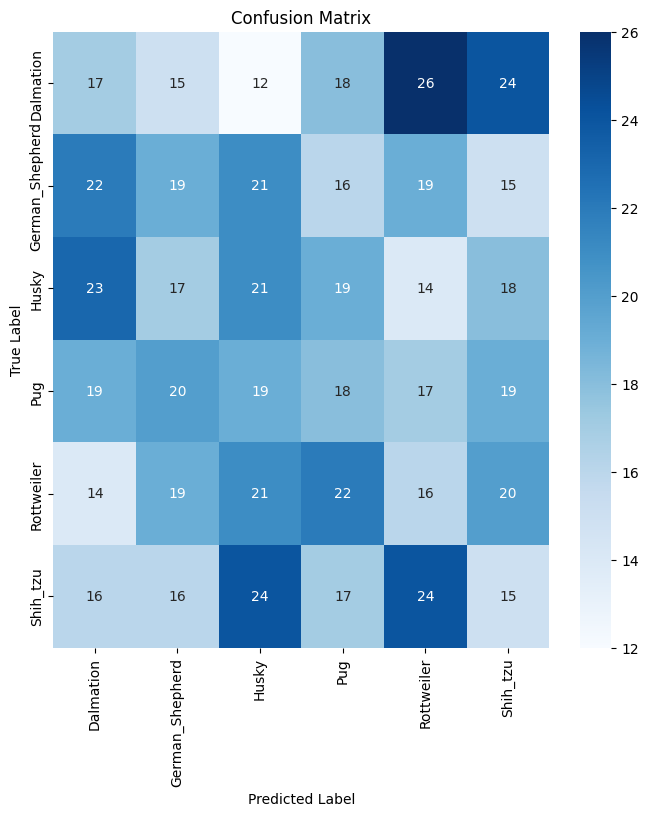

Precision: 0.16
Recall: 0.16
F1-Score: 0.16
Classification Report:
                 precision    recall  f1-score   support

      Dalmation       0.15      0.15      0.15       112
German_Shepherd       0.18      0.17      0.17       112
          Husky       0.18      0.19      0.18       112
            Pug       0.16      0.16      0.16       112
     Rottweiler       0.14      0.14      0.14       112
       Shih_tzu       0.14      0.13      0.13       112

       accuracy                           0.16       672
      macro avg       0.16      0.16      0.16       672
   weighted avg       0.16      0.16      0.16       672



In [ ]:
# Step 10: Confusion Matrix and Metrics
y_true = validation_generator.classes
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import Necessary Libraries
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Step 3: Load the Saved Model from Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/improved_dog_breed_model.keras'
try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading the model:", e)

# Step 4: Upload and Process an Image for Prediction
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # Get the uploaded file name

# Step 5: Preprocess the Image
img = load_img(img_path, target_size=(224, 224))  # Resize to the model's expected input size
img_array = img_to_array(img) / 255.0             # Normalize the image to [0, 1] range
img_array = np.expand_dims(img_array, axis=0)     # Add batch dimension

# Step 6: Make a Prediction
if 'model' in locals():
    try:
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions) * 100

        # Define Breed Labels based on encoding order
        breed_labels = {
            0: 'Dalmation',
            1: 'German_Shepherd',
            2: 'Husky',
            3: 'Pug',
            4: 'Rottweiler',
            5: 'Shih_tzu'
        }
        predicted_breed = breed_labels.get(predicted_class, "Unknown")
        print(f'Predicted Breed: {predicted_breed} with Confidence: {confidence_score:.2f}%')
    except Exception as e:
        print("Error during prediction:", e)
else:
    print("Model could not be loaded. Please check for model loading errors above.")


Mounted at /content/drive
Model loaded successfully!


Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Breed: Dalmation with Confidence: 100.00%


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define the labels
labels = ['Pug', 'Rottweiler', 'Shih_tzu', 'German_Shepherd', 'Husky', 'Dalmation']

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Display the encoded classes and their order
print("Classes (in order of encoding):", label_encoder.classes_)


Classes (in order of encoding): ['Dalmation' 'German_Shepherd' 'Husky' 'Pug' 'Rottweiler' 'Shih_tzu']


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/improved_dog_breed_model.keras'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Recreate the test data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dir = '/content/drive/MyDrive/Dog_Breed_Dataset/'
img_height, img_width = 224, 224
batch_size = 32

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Predict on the test data
test_generator.reset()
predictions = np.argmax(model.predict(test_generator), axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(true_labels, predictions, target_names=class_labels)
print("Classification Report:\n", report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


Mounted at /content/drive
Found 3360 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 27/105 ━━━━━━━━━━━━━━━━━━━━ 7:06 5s/step